In [1]:
# suppress any warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# make connection to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install lime

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import tensorflow as tf
from skimage.segmentation import mark_boundaries
from PIL import Image

In [5]:
class LIMEExplainer:
  def __init__(self, model_path, class_names=['Healthy', 'Leukemia']):
    """
    Initialize LIME explainer for leukemia detection
    """
    self.model = load_model(model_path)
    self.class_names = class_names

    # initialize LIME image explainer
    self.explainer = lime_image.LimeImageExplainer()

    print(f"Model loaded from: {model_path}")
    print(f"Model input shape: {self.model.input_shape}")
    print(f"Classes: {self.class_names}")

  def predict_fn(self, images):
    """
    Prediction function for LIME
    """
    # ensure images are in right format
    if len(images.shape) == 3:
      images = np.expand_dims(images, axis=0)

    # preprocess images
    processed_images = []
    for img in images:
      # resize to model input size if needed
      if img.shape[:2] != (226, 226):
        img_resized = cv2.resize(img, (226, 226))
      else:
        img_resized = img

      # convert to float and preprocess
      img_processed = preprocess_input(img_resized.astype(np.float32))
      processed_images.append(img_processed)

    processed_images = np.array(processed_images)

    # get predictions
    predictions = self.model.predict(processed_images, verbose=0)

    # ensure probabilities returned
    if predictions.shape[1] == 2: # binary classification
      # apply softmax to convert logits to probabilities
      predictions = tf.nn.softmax(predictions).numpy()

    return predictions

  def explain_image(self, img_path, num_samples=1000, num_features=5, hide_color=None, positive_only=True, save_path=None):
    """
    Generate LIME explanation for an image
    """
    # load image
    img = image.load_img(img_path, target_size=(226, 226))
    img_array = np.array(img)

    print(f"Explaining image: {img_path}")
    print(f"Image shape: {img_array.shape}")

    # get original prediction
    original_pred = self.predict_fn(np.expand_dims(img_array, axis=0))
    predicted_class = np.argmax(original_pred[0])
    confidence = original_pred[0][predicted_class]

    print(f"Original prediction: {self.class_names[predicted_class]} (confidence: {confidence:.3f})")

    # generate explanation
    print("Generating LIME explanation...")
    explanation = self.explainer.explain_instance(
      img_array,
      self.predict_fn,
      top_labels=len(self.class_names),
      hide_color=hide_color,
      num_samples=num_samples,
      segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)
    )

    # visualizations
    self._create_visualizations(
      img_array, explanation, predicted_class, confidence,
      num_features, positive_only, save_path
    )

    return explanation

  def _create_visualizations(self, img_array, explanation, predicted_class, confidence, num_features, positive_only, save_path):
    """
    Create and display LIME visualizations
    """
    # get image and mask for predicted class
    temp, mask = explanation.get_image_and_mask(
      predicted_class,
      positive_only=positive_only,
      num_features=num_features,
      hide_rest=False
    )

    # create boundary image
    boundary_img = mark_boundaries(temp / 255.0, mask)

    dict_heatmap = dict(explanation.local_exp[predicted_class])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # original image
    axes[0, 0].imshow(img_array)
    axes[0, 0].set_title(f'Original Image\\n{self.class_names[predicted_class]} (conf: {confidence:.3f})')
    axes[0, 0].axis('off')

    # LIME explanation with boundaries
    axes[0, 1].imshow(boundary_img)
    axes[0, 1].set_title(f'LIME Explanation\\n(Top {num_features} features)')
    axes[0, 1].axis('off')

    # heatmap visualization
    im = axes[1, 0].imshow(heatmap, cmap='RdYlBu', vmin=-heatmap.max(), vmax=heatmap.max())
    axes[1, 0].set_title('Feature Importance Heatmap')
    axes[1, 0].axis('off')
    plt.colorbar(im, ax=axes[1, 0], fraction=0.046)

    # segments visualization
    axes[1, 1].imshow(explanation.segments, cmap='tab20')
    axes[1, 1].set_title(f'Superpixel Segments\\n({len(np.unique(explanation.segments))} segments)')
    axes[1, 1].axis('off')

    plt.tight_layout()

    if save_path:
      plt.savefig(save_path, dpi=300, bbox_inches='tight')
      print(f"Saved explanation to: {save_path}")

    plt.show()

    # feature importance
    self._print_feature_importance(explanation, predicted_class, num_features)

  def _print_feature_importance(self, explanation, predicted_class, num_features):
    """
    Print feature importance scores
    """
    print(f"\\nTop {num_features} features for {self.class_names[predicted_class]}:")

    # get feature importance for predicted class
    feature_importance = explanation.local_exp[predicted_class]

    # sort by absolute importance
    sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

    for i, (feature, importance) in enumerate(sorted_features[:num_features]):
      impact = "Positive" if importance > 0 else "Negative"
      print(f"{i+1:2d}. Segment {feature:3d}: {importance:+.4f} ({impact} impact)")

  def compare_predictions(self, img_path, num_features=5, save_path=None):
    """
    Compare predictions with and without top features
    """
    # load image
    img = image.load_img(img_path, target_size=(226, 226))
    img_array = np.array(img)

    # get explanation
    explanation = self.explainer.explain_instance(
      img_array,
      self.predict_fn,
      top_labels=len(self.class_names),
      num_samples=1000,
      segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)
    )

    # original prediction
    original_pred = self.predict_fn(np.expand_dims(img_array, axis=0))
    predicted_class = np.argmax(original_pred[0])

    # image with only top features
    temp, mask = explanation.get_image_and_mask(
      predicted_class,
      positive_only=False,
      num_features=num_features,
      hide_rest=True
    )

    # predict on modified image
    modified_pred = self.predict_fn(np.expand_dims(temp, axis=0))

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # original image
    axes[0].imshow(img_array)
    axes[0].set_title(f'Original Image\\n{self.class_names[predicted_class]}: {original_pred[0][predicted_class]:.3f}')
    axes[0].axis('off')

    # modified image
    axes[1].imshow(temp)
    axes[1].set_title(f'Top {num_features} Features Only\\n{self.class_names[predicted_class]}: {modified_pred[0][predicted_class]:.3f}')
    axes[1].axis('off')

    # prediction comparison
    x_pos = np.arange(len(self.class_names))
    width = 0.35

    axes[2].bar(x_pos - width/2, original_pred[0], width, label='Original', alpha=0.8)
    axes[2].bar(x_pos + width/2, modified_pred[0], width, label='Top Features', alpha=0.8)

    axes[2].set_xlabel('Classes')
    axes[2].set_ylabel('Probability')
    axes[2].set_title('Prediction Comparison')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(self.class_names)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
      plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    return {
      'original_prediction': original_pred[0],
      'modified_prediction': modified_pred[0],
      'explanation': explanation
    }

In [6]:
def batch_lime_analysis(model_paths, test_images, num_samples=1000):
  """
  Run LIME analysis on multiple models and images
  """
  results = {}

  for model_name, model_path in model_paths.items():
    print(f"ANALYZING MODEL: {model_name}")

    try:
      explainer = LIMEExplainer(model_path)
      results[model_name] = {}

      for i, img_path in enumerate(test_images):
        print(f"\\nImage {i+1}: {img_path}")

        explanation = explainer.explain_image(
          img_path,
          num_samples=num_samples,
          save_path=f'lime_{model_name}_image_{i+1}.png'
        )

        results[model_name][f'image_{i+1}'] = explanation
    except Exception as e:
      print(f"Error with {model_name}: {e}")
      results[model_name] = None

  return results

In [7]:
def lime_model_comparison(model_paths, test_image, save_comparison=True):
  """
  Compare LIME explanations across different models for the same image
  """
  explanations = {}
  predictions = {}

  # generate explanations for each model
  for model_name, model_path in model_paths.items():
    print(f"\\nAnalyzing with {model_name}...")
    try:
      explainer = LIMEExplainer(model_path)
      explanation = explainer.explain_image(test_image, num_samples=500)
      explanations[model_name] = explanation

      img = image.load_img(test_image, target_size=(226, 226))
      img_array = np.array(img)
      pred = explainer.predict_fn(np.expand_dims(img_array, axis=0))
      predictions[model_name] = pred[0]
    except Exception as e:
      print(f"Error with {model_name}: {e}")

  # comparison visualization
  if explanations:
    create_lime_comparison_plot(test_image, explanations, predictions, save_comparison)

  return explanations, predictions

In [8]:
def create_lime_comparison_plot(img_path, explanations, predictions, save_path=True):
  """
  Create a comparison plot of LIME explanations from different models
  """
  num_models = len(explanations)
  class_names = ['Healthy', 'Leukemia']

  # load original image
  img = image.load_img(img_path, target_size=(226, 226))
  img_array = np.array(img)

  fig, axes = plt.subplots(2, num_models + 1, figsize=(4 * (num_models + 1), 8))

  # original image (first column)
  axes[0, 0].imshow(img_array)
  axes[0, 0].set_title('Original Image')
  axes[0, 0].axis('off')

  axes[1, 0].axis('off') # empty space

  # model explanations
  for i, (model_name, explanation) in enumerate(explanations.items()):
    col = i + 1
    predicted_class = np.argmax(predictions[model_name])
    confidence = predictions[model_name][predicted_class]

    # get explanation visualization
    temp, mask = explanation.get_image_and_mask(
      predicted_class,
      positive_only=False,
      num_features=5,
      hide_rest=False
    )

    boundary_img = mark_boundaries(temp / 255.0, mask)

    # plot explanation
    axes[0, col].imshow(boundary_img)
    axes[0, col].set_title(f'{model_name}\\n{class_names[predicted_class]} ({confidence:.3f})')
    axes[0, col].axis('off')

    # plot heatmap
    dict_heatmap = dict(explanation.local_exp[predicted_class])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

    im = axes[1, col].imshow(heatmap, cmap='RdYlBu', vmin=-abs(heatmap).max(), vmax=abs(heatmap).max())
    axes[1, col].set_title(f'{model_name} Heatmap')
    axes[1, col].axis('off')

  plt.tight_layout()

  if save_path:
    plt.savefig('lime_model_comparison.png', dpi=300, bbox_inches='tight')
    print("Saved comparison to: lime_model_comparison.png")

  plt.show()

In [9]:
# quick start function
def quick_lime_analysis(model_path, image_path):
  """
  Quick LIME analysis with default settings
  """
  explainer = LIMEExplainer(model_path)
  explanation = explainer.explain_image(image_path, num_samples=1000, num_features=5)
  return explanation

In [10]:
# model analysis
def smart_lime_analysis(model_path, image_path):
  """
  Automatically detect model type and use appropriate explainer
  """
  explainer = LIMEExplainer(model_path)
  explanation = explainer.explain_image(image_path, num_samples=1000, num_features=5)
  print("Used regular LIME explainer (CNN)")
  return explanation

# usage for mixed model types:
def analyze_all_models(model_paths, leukemia_image, healthy_image):
  """
  Analyze all models with appropriate explainers
  """
  results = {}

  for model_name, model_path in model_paths.items():
    print(f"Analyzing {model_name}")

    try:
      # try smart analysis that detects model type
      leukemia_result = smart_lime_analysis(model_path, leukemia_image)
      healthy_result = smart_lime_analysis(model_path, healthy_image)

      results[model_name] = {
        'leukemia': leukemia_result,
        'healthy': healthy_result
      }

    except Exception as e:
      print(f"Error analyzing {model_name}: {e}")
      results[model_name] = None

  return results

In [11]:
healthy_cell = "/content/drive/My Drive/C-NMC/training_data/fold_0/hem/UID_H6_1_1_hem.bmp"
cancer_cell = "/content/drive/My Drive/C-NMC/training_data/fold_0/all/UID_1_3_1_all.bmp"

cnn_unbalanced = "/content/drive/My Drive/code/CNNs/unbalanced-cnn/cnn_unbalanced_model.keras"

In [12]:
models = {"cnn_unbalanced":"/content/drive/My Drive/code/CNNs/unbalanced-cnn/cnn_unbalanced_model.keras"}

Analyzing cnn_unbalanced
Model loaded from: /content/drive/My Drive/code/CNNs/unbalanced-cnn/cnn_unbalanced_model.keras
Model input shape: (None, 226, 226, 3)
Classes: ['Healthy', 'Leukemia']
Explaining image: /content/drive/My Drive/C-NMC/training_data/fold_0/all/UID_1_3_1_all.bmp
Image shape: (226, 226, 3)
Original prediction: Healthy (confidence: 1.000)
Generating LIME explanation...


  0%|          | 0/1000 [00:00<?, ?it/s]

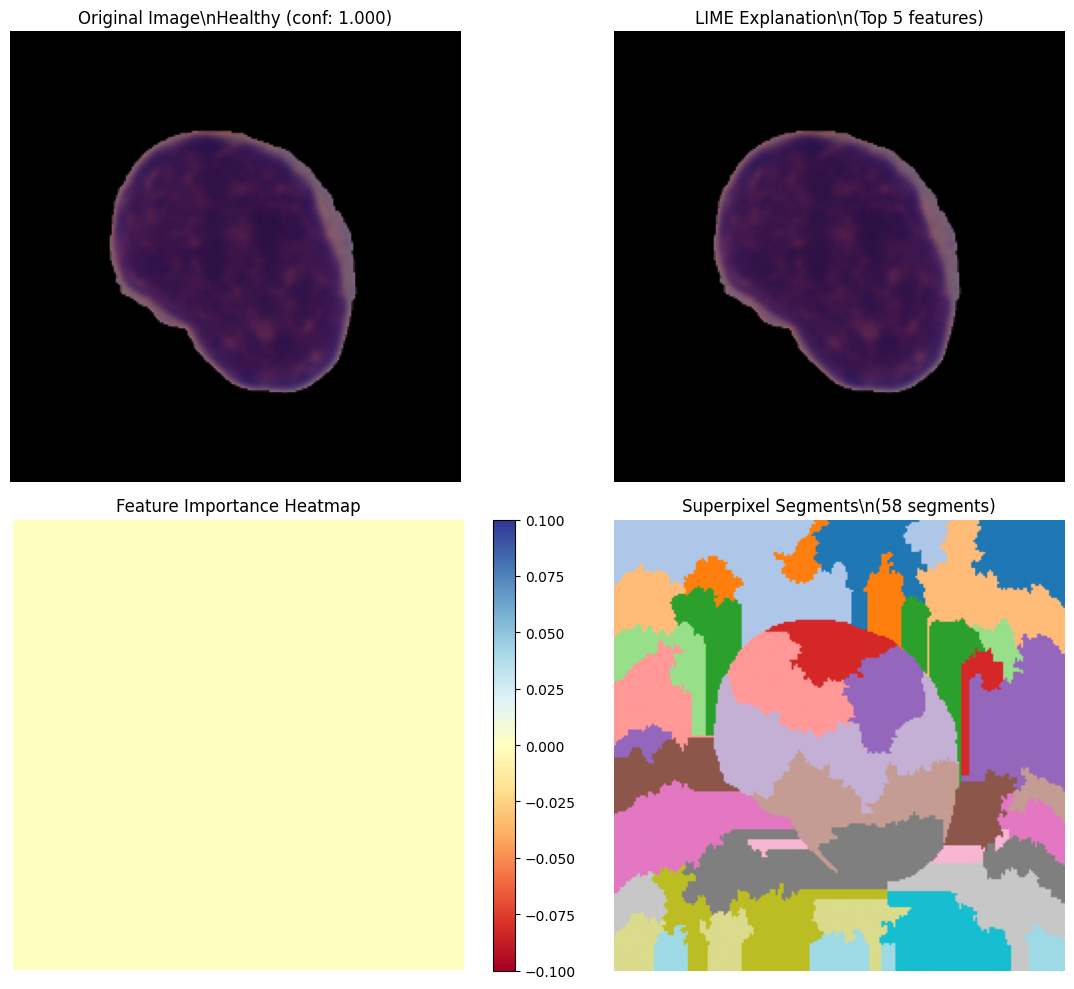

\nTop 5 features for Healthy:
 1. Segment   0: +0.0000 (Negative impact)
 2. Segment   1: +0.0000 (Negative impact)
 3. Segment   2: +0.0000 (Negative impact)
 4. Segment   3: +0.0000 (Negative impact)
 5. Segment   4: +0.0000 (Negative impact)
Used regular LIME explainer (CNN)
Model loaded from: /content/drive/My Drive/code/CNNs/unbalanced-cnn/cnn_unbalanced_model.keras
Model input shape: (None, 226, 226, 3)
Classes: ['Healthy', 'Leukemia']
Explaining image: /content/drive/My Drive/C-NMC/training_data/fold_0/hem/UID_H6_1_1_hem.bmp
Image shape: (226, 226, 3)
Original prediction: Healthy (confidence: 1.000)
Generating LIME explanation...


  0%|          | 0/1000 [00:00<?, ?it/s]

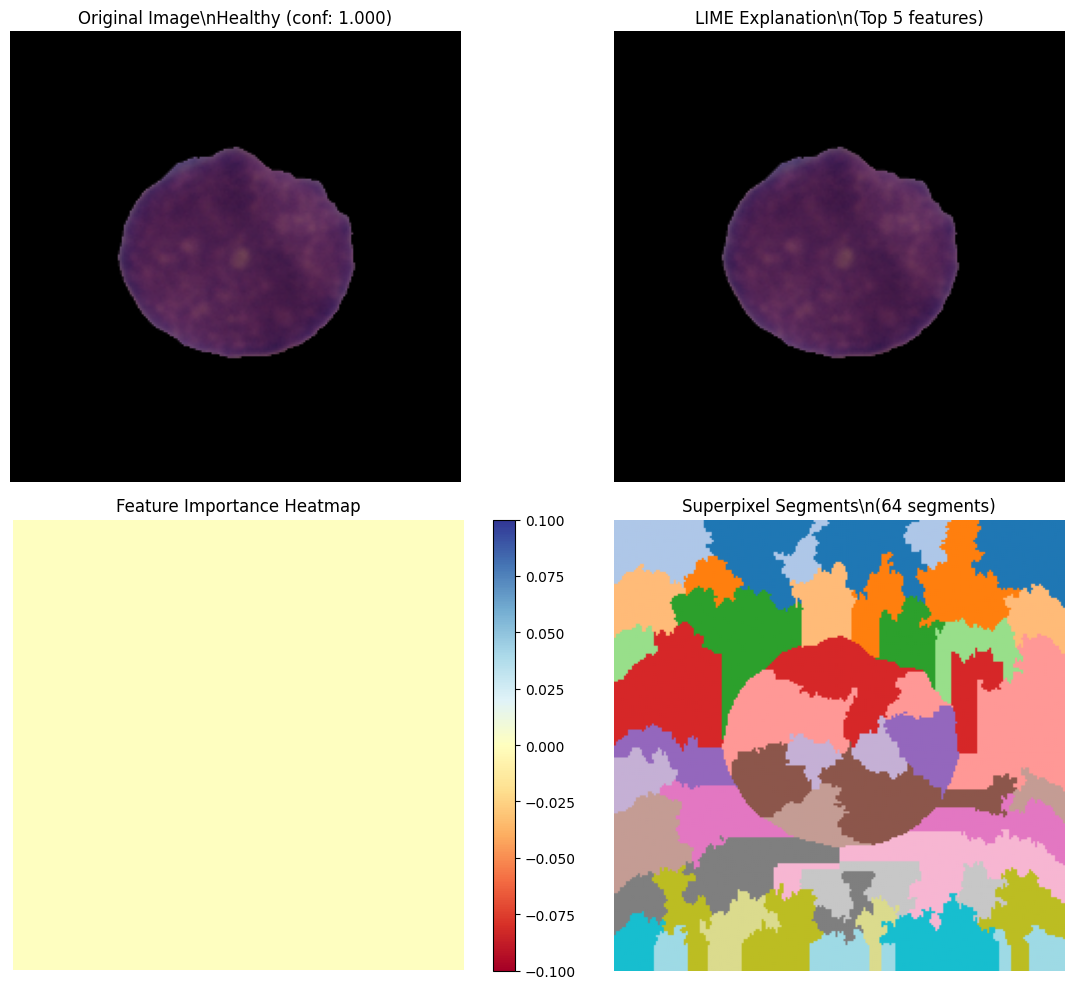

\nTop 5 features for Healthy:
 1. Segment   0: +0.0000 (Negative impact)
 2. Segment   1: +0.0000 (Negative impact)
 3. Segment   2: +0.0000 (Negative impact)
 4. Segment   3: +0.0000 (Negative impact)
 5. Segment   4: +0.0000 (Negative impact)
Used regular LIME explainer (CNN)


In [13]:
results = analyze_all_models(models, cancer_cell, healthy_cell)